## Importy

In [1]:
import pandas as pd
import numpy as np
import string
import json
from IPython.display import display
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from emoji import UNICODE_EMOJI
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from  datetime import datetime

pd.options.display.max_columns = None
# Use 'display(df)' instead of 'df' to display all columns.

[nltk_data] Downloading package wordnet to /home/lilatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lilatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Ładowanie danych

### US region

In [2]:
ytUS_df = pd.read_csv("./data/youtube_data/US_videos_5p.csv", sep=';')
ytUS_df["region"] = "US"
print(ytUS_df.shape)
ytUS_df.head(1)

(40949, 17)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,NaN,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,US


### GB region

In [3]:
# Encoding error. Open GB_videos_5p.csv in VSCode and save file as UTF-16 LE.
ytGB_df = pd.read_csv("./data/youtube_data/GB_videos_5p.csv", sep=';', encoding='utf_16')
ytGB_df["region"] = "GB"
print(ytGB_df.shape)
ytGB_df.head(1)

(38916, 17)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB


### Scalenie obu regionów

In [4]:
df = pd.concat([ytGB_df, ytUS_df], ignore_index=True)
print(df.shape)
df.rename(columns={"description ": "description"}, inplace=True)
df.head(1)

(79865, 17)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB


## Dodanie nowych kolumn

In [5]:
RE_HTTP = re.compile("http[s]?://[/\.a-zA-Z0-9]+")
def getListOfURLs(text):
    return RE_HTTP.findall(str(text))

def countEmojis(text):
    count = 0
    for em in UNICODE_EMOJI['en'].keys():
        if em in str(text):
            count += 1
    return count

# formatowanie czasu i rozbicie na atrybuty  
def addColumnsAndSaveCSV(df, pathToSave):
    ###### Adam ######
    for index, row in df.iterrows():    
        pubdate = datetime.strptime(row['publish_time'],'%Y-%m-%dT%H:%M:%S.%fZ')
        df.loc[index,'pub_date'] = pubdate
        df.loc[index,'pub_day_of_the_weak'] = pubdate.weekday()
        df.loc[index,'pub_year'] = pubdate.year
        df.loc[index,'pub_month'] = pubdate.month
        df.loc[index,'pub_day'] = pubdate.day
        df.loc[index,'pub_hour'] = pubdate.hour
        trendate = datetime.strptime(row['trending_date'] + ' 23:59','%y.%d.%m %H:%M') # Wymuszamy godzinę 23:59
        df.loc[index,'tren_date'] = trendate
        df.loc[index,'tren_day_of_the_weak'] = trendate.weekday()
        df.loc[index,'tren_year'] = trendate.year
        df.loc[index,'tren_month'] = trendate.month
        df.loc[index,'tren_day'] = trendate.day
        df.loc[index,'time_to_trend_in_days'] = (trendate - pubdate).total_seconds()/(3600*24)


    # stosunek likes, dislikes, views
    df['dislikes/likes'] = df['dislikes']/df['likes']
    df['likes/views'] = df['likes']/df['views']
    df['dislikes/views'] = df['dislikes']/df['views']
    df['comment_count/views'] = df['comment_count']/df['views']
    unique = df['video_id'].unique()

    for uid in unique:
        temp = df[df['video_id']==uid]
        times_in_trend = len(temp)
        increase_views = 0
        increase_likes = 0
        increase_dislikes = 0
        increase_comms = 0
        indexes =  temp.index.values.tolist() 
        if times_in_trend > 1:
            increase_views = temp['views'][indexes[1]] - temp['views'][indexes[0]]
            increase_likes = temp['likes'][indexes[1]] - temp['likes'][indexes[0]]
            increase_dislikes = temp['dislikes'][indexes[1]] - temp['dislikes'][indexes[0]]
            increase_comms = temp['comment_count'][indexes[1]] - temp['comment_count'][indexes[0]]

        df.loc[indexes[0],'increase_views'] = increase_views
        df.loc[indexes[0],'increase_likes'] = increase_likes
        df.loc[indexes[0],'increase_dislikes'] = increase_dislikes
        df.loc[indexes[0],'increase_comms'] = increase_comms
        df.loc[indexes[0],'times_in_trend'] = times_in_trend
        df.loc[indexes[0],'avg_views'] = np.mean(temp['views'])
        df.loc[indexes[0],'avg_likes'] = np.mean(temp['likes'])
        df.loc[indexes[0],'avg_dislikes'] = np.mean(temp['dislikes'])
        df.loc[indexes[0],'avg_comms'] = np.mean(temp['comment_count'])
#         df.loc[indexes[0],'avg_views_increase_per_hour'] = temp['views'][0] / temp['time_to_trend_in_days'][0]
    df = df[df['avg_comms'] >= 0] 
    
    df["avg_views_increase_per_hour"] = df.apply(lambda row: row.views/row.time_to_trend_in_days, axis=1)
    ###### Marcin ######
    df["title_length"] = df.apply(lambda row: len(row.title), axis=1)

    df["description_length"] = df.apply(lambda row: len(str(row.description)), axis=1)

    df['tags'] = df['tags'].apply(lambda tag: json.dumps(tag.replace('"','').split('|')))
    df["n_of_tags"] = df.apply(lambda row: len(json.loads(row.tags)), axis=1)

    df["title_capital_letters"] = df.apply(lambda row: sum(1 for l in row.title if l.isupper()), axis=1)
    df["title_capital_letters_percent"] = df.apply(lambda row: row.title_capital_letters/row.title_length, axis=1)
    df["title_small_letters"] = df.apply(lambda row: sum(1 for l in row.title if l.islower()), axis=1)
    df["title_small_letters_percent"] = df.apply(lambda row: row.title_small_letters/row.title_length, axis=1)

    df["title_punctuation"] = df.apply(lambda row: sum(1 for l in row.title if l in string.punctuation), axis=1)
    df["title_punctuation_percent"] = df.apply(lambda row: sum(1 for l in row.title if l in string.punctuation)/len(row.title), axis=1)

    df["title_n_of_emojis"] = df.apply(lambda row: str(countEmojis(row.title)), axis=1)

    df["desc_capital_letters"] = df.apply(lambda row: sum(1 for l in str(row.description) if l.isupper()), axis=1)
    df["desc_capital_letters_percent"] = df.apply(lambda row: row.desc_capital_letters/row.description_length, axis=1)
    df["desc_small_letters"] = df.apply(lambda row: sum(1 for l in str(row.description) if l.islower()), axis=1)
    df["desc_small_letters_percent"] = df.apply(lambda row: row.desc_small_letters/row.description_length, axis=1)

    df["desc_punctuation"] = df.apply(lambda row: sum(1 for l in RE_HTTP.sub(' ', str(row.description).replace(r'\n', ' ')) if l in string.punctuation), axis=1)
    df["desc_punctuation_percent"] = df.apply(lambda row: sum(1 for l in str(row.description) if l in string.punctuation)/len(str(row.description)), axis=1)

    df["desc_list_of_urls"] = df.apply(lambda row: str(getListOfURLs(row.description)), axis=1)
    df["desc_n_of_urls"] = df.apply(lambda row: len(getListOfURLs(row.description)), axis=1)
    df["desc_n_of_emojis"] = df.apply(lambda row: str(countEmojis(row.description)), axis=1)
    
    
    df.to_csv(pathToSave)
    return df



In [6]:
df = addColumnsAndSaveCSV(df, "./whole_YT_with_new_columns.csv")

/mnt/d/Dokumenty/Projekty/Hack4Env/venv/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/d/Dokumenty/Projekty/Hack4Env/venv/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/d/Dokumenty/Projekty/Hack4Env/venv/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [10]:
df[:3]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,region,pub_date,pub_day_of_the_weak,pub_year,pub_month,pub_day,pub_hour,tren_date,tren_day_of_the_weak,tren_year,tren_month,tren_day,time_to_trend_in_days,dislikes/likes,likes/views,dislikes/views,comment_count/views,increase_views,increase_likes,increase_dislikes,increase_comms,times_in_trend,avg_views,avg_likes,avg_dislikes,avg_comms,avg_views_increase_per_hour,title_length,description_length,n_of_tags,title_capital_letters,title_capital_letters_percent,title_small_letters,title_small_letters_percent,title_punctuation,title_punctuation_percent,title_n_of_emojis,desc_capital_letters,desc_capital_letters_percent,desc_small_letters,desc_small_letters_percent,desc_punctuation,desc_punctuation_percent,desc_list_of_urls,desc_n_of_urls,desc_n_of_emojis
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"[""christmas"", ""john lewis christmas"", ""john le...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,GB,2017-11-10 07:38:29,4.0,2017.0,11.0,10.0,7.0,2017-11-14 23:59:00,1.0,2017.0,11.0,14.0,4.680914,0.184030,0.007707,0.001418,0.001312,338739.0,2528.0,612.0,-2359.0,18.0,8.097972e+06,60878.555556,11630.833333,7909.500000,1.543398e+06,45,821,9,7,0.155556,26,0.577778,2,0.044444,0,39,0.047503,608,0.740560,9,0.085262,"['http://bit.ly/2mboXgj', 'http://bit.ly/2hg04...",7,0
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"[""SNL"", ""Saturday Night Live"", ""SNL Season 43""...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...,GB,2017-11-12 06:24:44,6.0,2017.0,11.0,12.0,6.0,2017-11-14 23:59:00,1.0,2017.0,11.0,14.0,2.732130,0.089746,0.024260,0.002177,0.002617,615290.0,8211.0,783.0,715.0,3.0,1.499560e+06,31691.333333,2861.666667,3271.333333,3.856450e+05,41,417,36,8,0.195122,20,0.487805,5,0.121951,0,40,0.095923,276,0.661871,18,0.167866,"['http://www.nbc.com/saturday', 'http://www.nb...",7,0
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"[""Eminem"", ""Walk"", ""On"", ""Water"", ""Aftermath/S...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...,GB,2017-11-10 17:00:03,4.0,2017.0,11.0,10.0,17.0,2017-11-14 23:59:00,1.0,2017.0,11.0,14.0,4.290938,0.055142,0.045891,0.002531,0.007336,3380838.0,53222.0,4295.0,-1646.0,19.0,2.810155e+07,926578.736842,54665.315789,129223.000000,3.998795e+06,42,594,6,6,0.142857,25,0.595238,4,0.095238,0,29,0.048822,433,0.728956,9,0.158249,"['http://shady.sr/WOWEminem', 'https://goo.gl/...",14,0


## Wizualizacja ciekawszych danych

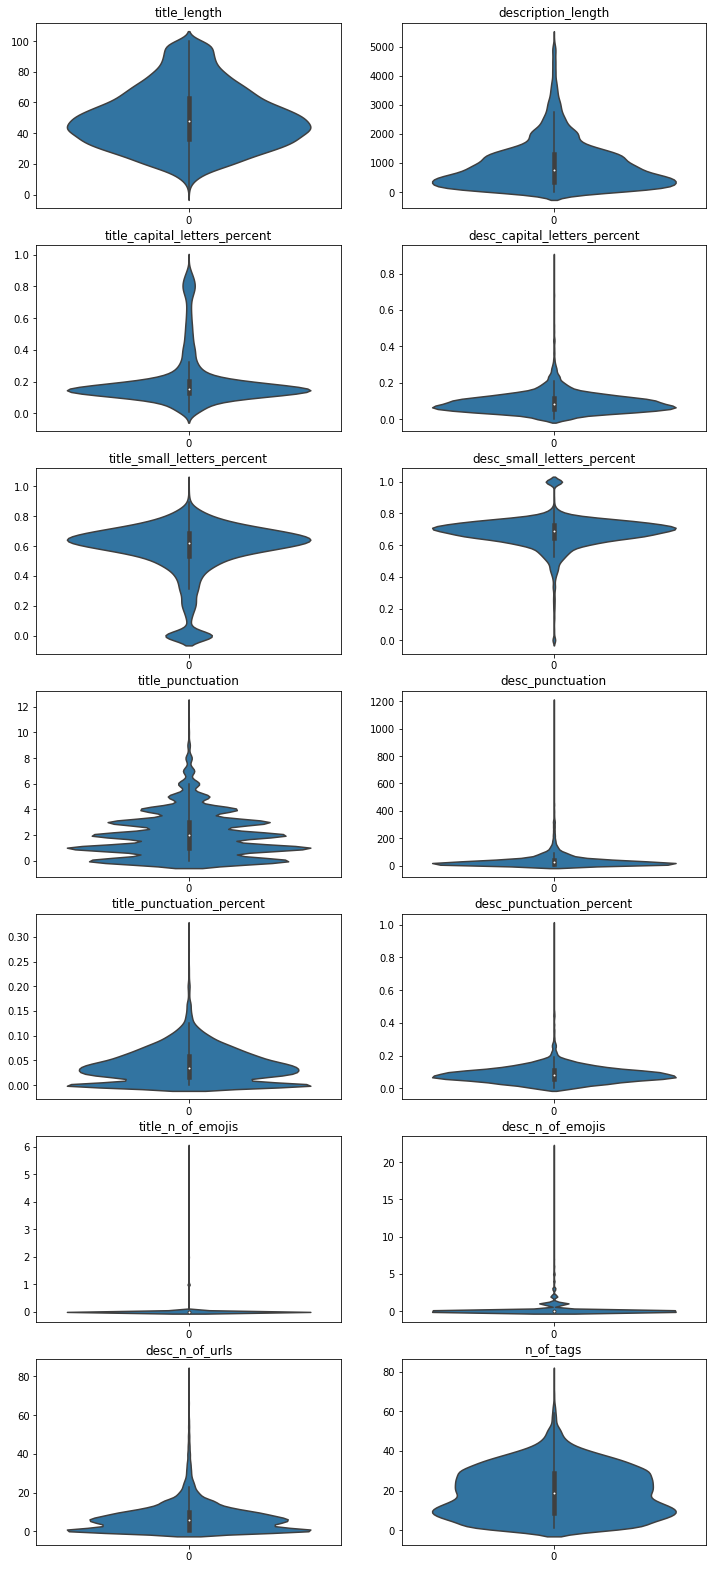

In [9]:
list_of_columns = [
    "title_length", "description_length", 
#     "title_capital_letters", "desc_capital_letters", 
    "title_capital_letters_percent", "desc_capital_letters_percent", 
#     "title_small_letters", "desc_small_letters", 
    "title_small_letters_percent",  "desc_small_letters_percent", 
    "title_punctuation", "desc_punctuation",
    "title_punctuation_percent", "desc_punctuation_percent",
    "title_n_of_emojis", "desc_n_of_emojis",
    "desc_n_of_urls",  "n_of_tags"
                  ]
n_of_cols = 2
n_of_rows = int(len(list_of_columns)/n_of_cols)
fig, axes = plt.subplots(n_of_rows, n_of_cols, figsize=(n_of_cols*6, n_of_rows*4))

data = df.loc[:, list_of_columns]
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ax.set_title(list_of_columns[i*n_of_cols+j])
        sns.violinplot(ax=ax,data=df.loc[:, list_of_columns[i*n_of_cols+j]])

### 20 najpopularniejszych słów w tagach

Text(0.5, 1.0, 'Najpopularniejsze tagi')

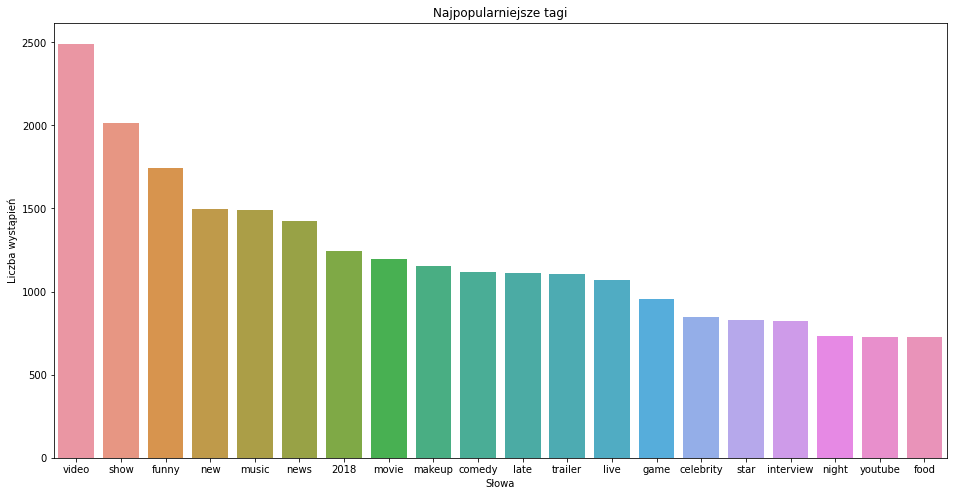

In [11]:
all_tags_words = []
for tags in df.loc[:,"tags"]:
    tags = json.loads(tags.lower())
    single_words = ' '.join(tags).split(' ')
    all_tags_words.extend(single_words)
    
all_words_without_stopwords = [word for word in all_tags_words if word not in stopwords.words('english')]

wnl = WordNetLemmatizer()
all_words_lemmatized = [wnl.lemmatize(word) for word in all_words_without_stopwords]


cnt_tags = Counter(all_words_lemmatized)
cnt_tags = cnt_tags.most_common()

xx, yy = zip(*cnt_tags[:20])
plt.figure(figsize=(16,8))
sns.barplot(x=list(xx),y=list(yy))
plt.xlabel("Słowa")
plt.ylabel("Liczba wystąpień")
plt.title("Najpopularniejsze tagi")

### 20 najpopularniejszych słów w tytułach

Text(0.5, 1.0, 'Najpopularniejsze słowa w tytułach')

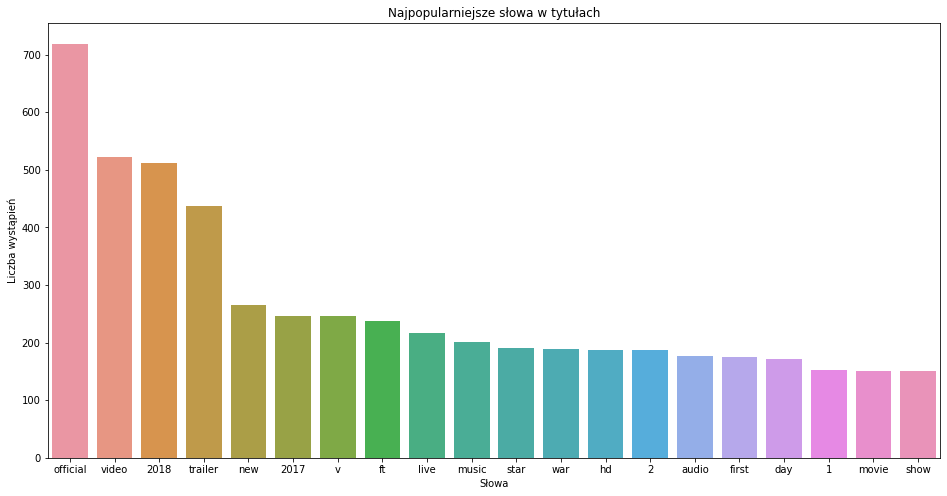

In [12]:
def removePunctuationInString(text):
    new_text = [char for char in text if char not in string.punctuation]
    return ''.join(new_text)

all_words_title = []
for title in df.loc[:,"title"]:
    title = title.lower()
    single_words = title.split(' ')
    all_words_title.extend(single_words)
    
all_words_title = [removePunctuationInString(word) for word in all_words_title]
all_words_title_without_stopwords = [word for word in all_words_title if word not in stopwords.words('english') and word is not '']

wnl = WordNetLemmatizer()
all_words_title_lemmatized = [wnl.lemmatize(word) for word in all_words_title_without_stopwords]


cnt_title = Counter(all_words_title_lemmatized)
cnt_title = cnt_title.most_common()

xx, yy = zip(*cnt_title[:20])
plt.figure(figsize=(16,8))
sns.barplot(x=list(xx),y=list(yy))
plt.xlabel("Słowa")
plt.ylabel("Liczba wystąpień")
plt.title("Najpopularniejsze słowa w tytułach")

In [ ]:
def describeAfter(df):

    min_ = df[['views','likes','dislikes','comment_count']]

    print("Begining of the timeline  {0}".format(df["tren_date"].min()))
    print("End of the timeline  {0}".format(df["tren_date"].max()))
    
    print("Begining of the pub timeline  {0}".format(df["pub_date"].min()))
    print("End of the pub timeline  {0}".format(df["pub_date"].max()))
    
    print("\n\nDescription of most common stats for a video:\n")
    print(df.describe()[['views','likes','dislikes','comment_count']])

    sns.set_style("whitegrid")
    data = df[['views','likes','dislikes','comment_count']]
    ax = sns.boxplot( data=data)
    ax.set(yscale="log")
    plt.show()

    
    print("\n\nDescription of most common stats proportions for a video:\n")
#     print(df.describe()[['dislikes/likes','likes/views','dislikes/views','comment_count/views']])

    sns.set_style("whitegrid")
    data = df[['dislikes/likes','likes/views','dislikes/views','comment_count/views']]
    ax = sns.boxplot( data=data)
    ax.set(yscale="log")
    plt.show()

    
    print("\n Increase in stats after getting in to trending (only increase after first day)")
        
    sns.set_style("whitegrid")
    data = df[['increase_views','increase_likes','increase_dislikes','increase_comms']]
    ax = sns.boxplot( data=data)
    ax.set(yscale="log")
    plt.show()

    
    
    
#     Time since publication to first apearence in trending
    print("\n\nTime since publication until showing up on trending:\n")
    print(df.describe()[['time_to_trend']])
    
    sns.set_style("whitegrid")
    data = df[['time_to_trend']]
    ax = sns.boxplot( data=data)
    ax.set(yscale="log")
    plt.show()


#     bar plot  of pub_day_of_the_weak


    print("\n")
    print("\n")

#     Colors for year 
# TODO weak - week
    print("\n")
    data17 = df[df["tren_year"]==2017]['pub_day_of_the_weak'].value_counts(sort=False)[df["pub_day_of_the_weak"].unique()]
    data18 = df[df["tren_year"]==2018]['pub_day_of_the_weak'].value_counts(sort=False)[df["pub_day_of_the_weak"].unique()]

    days = data17.keys()#[0,6,4,5,3,1,2]
    
    fig, ax = plt.subplots()
    ax.bar(days,data17,0.35,label="2017")
    ax.bar(days,data18,0.35,bottom=data17,label="2018")
    ax.set_xlabel ('Day of Week')
    ax.set_ylabel ('Number of videos')
    plt.title("Number of videos per day of week (pub day)")
    ax.legend()

    plt.show()

    print("\n")
    data17 = df[df["tren_year"]==2017]['tren_day_of_the_weak'].value_counts(sort=False)[df["tren_day_of_the_weak"].unique()]
    data18 = df[df["tren_year"]==2018]['tren_day_of_the_weak'].value_counts(sort=False)[df["tren_day_of_the_weak"].unique()]

    days = data17.keys()#[0,6,4,5,3,1,2]
    print(data17)
    print(data18)
    print(days)
    
    fig, ax = plt.subplots()
    ax.bar(days,data17,0.35,label="2017")
    ax.bar(days,data18,0.35,bottom=data17,label="2018")
    ax.set_xlabel ('Day of Week')
    ax.set_ylabel ('Number of videos')
    plt.title("Number of videos per day of week (tren day)")
    ax.legend()

    plt.show()

    
    print("\n")
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    data = df['tren_month'].value_counts(sort=False).sort_index()
#     print(data)
    months = data.keys()
    ax1.bar(months,data)
    ax1.set_xlabel ('Month')
    ax1.set_ylabel ('Number of videos')
#     plt.title("Number of videos per month (first time trending date)")
#     plt.show()
    
    print("\n")
    data = df['pub_month'].value_counts(sort=False).sort_index()
#     print(data)
    months = data.keys()
    ax2.bar(months,data)
    ax2.set_xlabel ('Month')
#     ax2.set_ylabel ('Number of videos')
    plt.title("Number of videos per month left-first time trending date right-publication date")
    plt.show()


    
describeAfter(new_ytUS)